In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.optim as optim
from training_utils import CIFAR10_dataloaders, training_monitor, print_model_size

In [2]:
# PatchEmbedding module: splits image into patches, projects to embed_dim, and adds positional embeddings.
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=128):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        # Use a conv layer to extract patches and project them.
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        # Learnable positional embeddings.
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))
    
    def forward(self, x):
        # x: (B, in_channels, img_size, img_size)
        x = self.proj(x)           # -> (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)           # -> (B, embed_dim, num_patches)
        x = x.transpose(1, 2)      # -> (B, num_patches, embed_dim)
        x = x + self.pos_embed     # Add positional embeddings.
        return x

# TransformerEncoderBlock: a custom module for one transformer encoder block.
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, nhead, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, dropout=dropout)
        self.norm2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, int(d_model * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(d_model * mlp_ratio), d_model),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        # x shape: (B, seq_len, d_model)
        # MultiheadAttention expects (seq_len, B, d_model), so transpose.
        x_norm = self.norm1(x)
        x_attn, _ = self.attn(x_norm.transpose(0, 1), x_norm.transpose(0, 1), x_norm.transpose(0, 1))
        x_attn = x_attn.transpose(0, 1)  # Back to (B, seq_len, d_model)
        x = x + x_attn                  # Residual connection.
        x = x + self.mlp(self.norm2(x)) # Second residual connection after the MLP.
        return x

# VisionTransformer model: combines patch embedding, a sequential chain of transformer blocks, and a classification head.
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, num_classes=10,
                 embed_dim=128, depth=6, nhead=4, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        # Build transformer encoder blocks as one nn.Sequential chain.
        self.transformer = nn.Sequential(*[
            TransformerEncoderBlock(embed_dim, nhead, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
    
    def forward(self, x):
        # Patch embed: (B, num_patches, embed_dim)
        x = self.patch_embed(x)
        # Transformer blocks: (B, num_patches, embed_dim)
        x = self.transformer(x)
        x = self.norm(x)
        # Global average pooling over the sequence of patches.
        x = x.mean(dim=1)
        x = self.head(x)
        return x

In [3]:
print_model_size(VisionTransformer())

Total params = 1.205642e+06
Trainable params = 1.205642e+06


Files already downloaded and verified


Files already downloaded and verified


  0%|          | 0/30 [00:00<?, ?it/s]

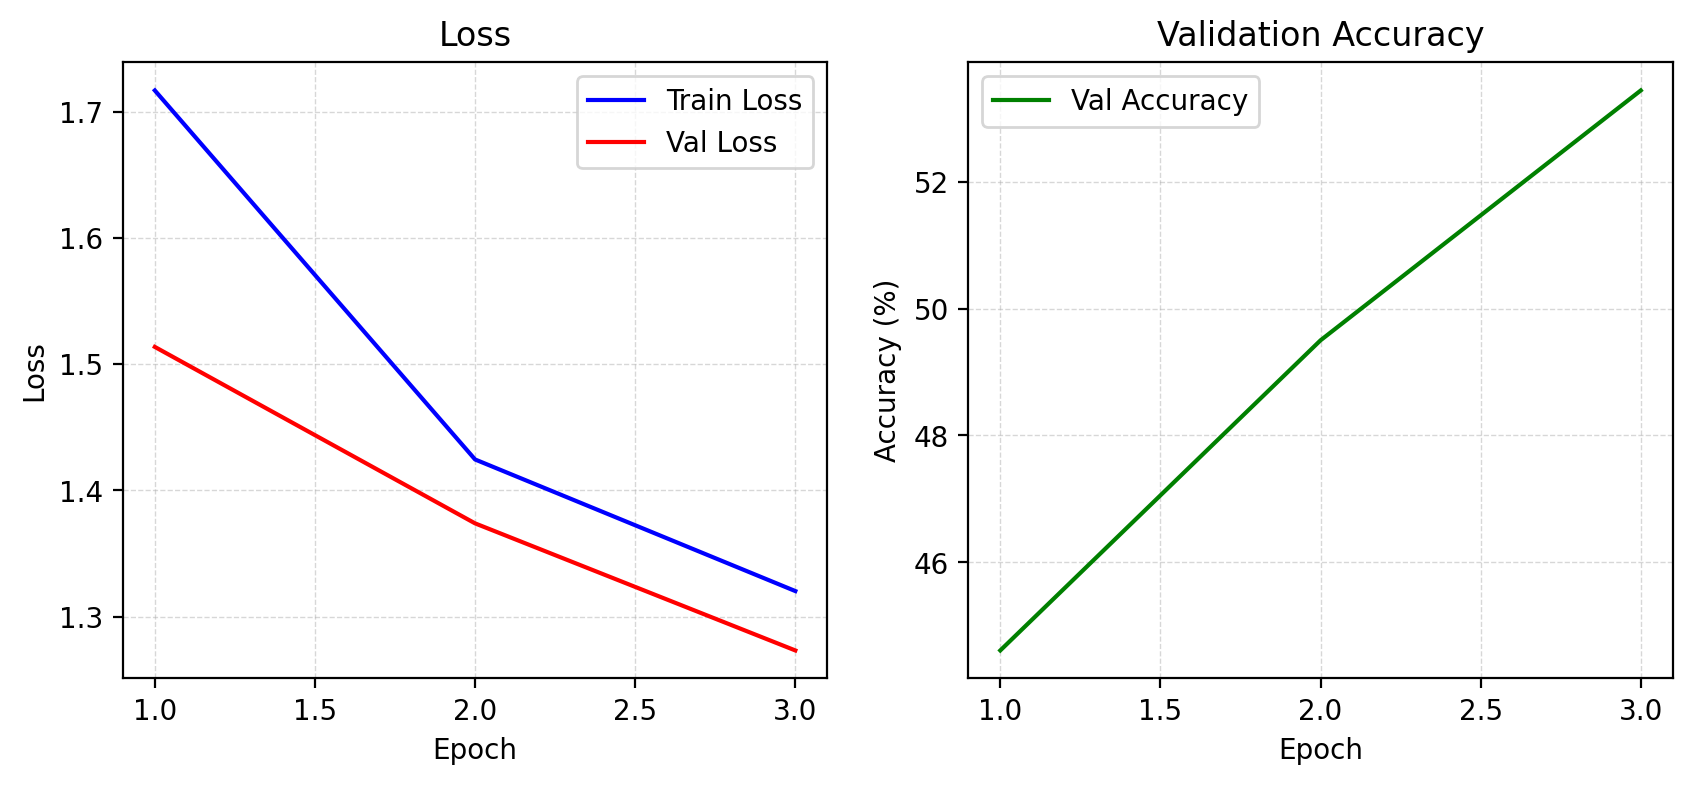

Epoch 3/30:  10%|#         | 3/30 [01:59<17:53, 39.77s/it]

|       Epoch        |     Train loss     |  Validation loss   | Validation accuracy, %  |
__________________________________________________________________________________________
|         1          |       1.7168       |       1.5136       |         44.6100         |
|         2          |       1.4244       |       1.3738       |         49.5000         |
|         3          |       1.3202       |       1.2731       |         53.4400         |


KeyboardInterrupt: 

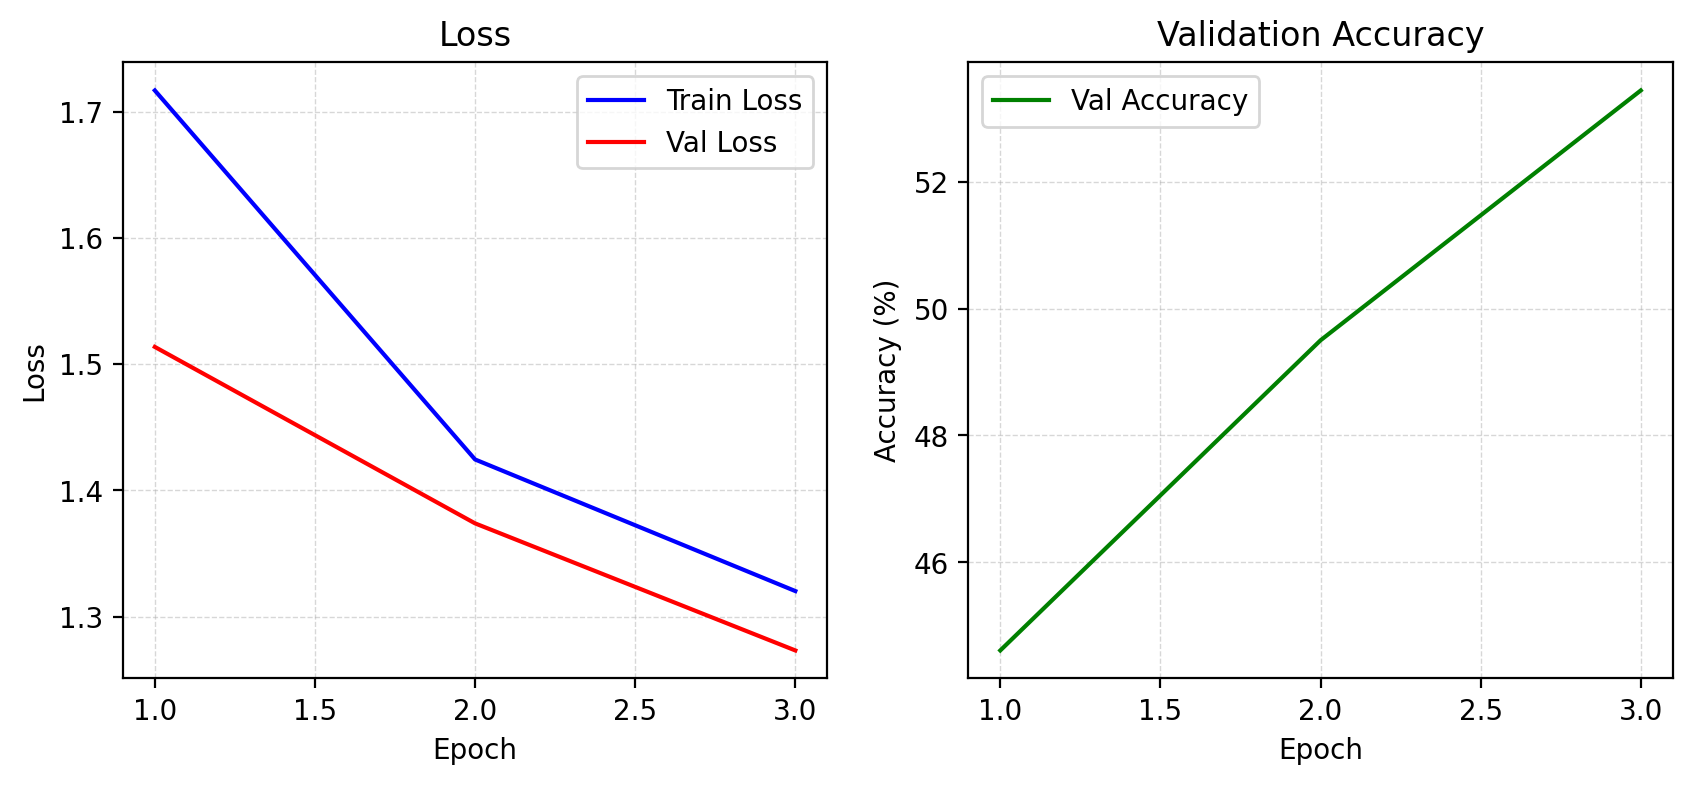

In [4]:
trainloader, testloader, classes = CIFAR10_dataloaders(batch_size=64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30

trained_model = training_monitor(device, model, optimizer, criterion, num_epochs, trainloader, testloader)
